<a href="https://colab.research.google.com/github/felipequinto/curso_fastai/blob/main/aula_01_estudos_fastai_classificacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pacotes

In [16]:
!pip install -Uqq ddgs pillow-heif


#Imports

In [17]:
import socket
import warnings
from time import sleep
from pathlib import Path

from ddgs import DDGS
from fastcore.all import L
from fastdownload import download_url
from pillow_heif import register_heif_opener
from fastai.vision.all import *
from google.colab import files

Ajustes

In [18]:
warnings.filterwarnings("ignore", category=ResourceWarning)
register_heif_opener()

# Teste de conectividade


In [19]:
try:
  with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
    s.settimeout(1)
    s.connect(("1.1.1.1", 53))
except (socket.timeout, OSError) as e:
  raise ConnectionError("STOP: Sem internet. Ajuste sua conectividade no ambiente.") from e

# Step_01: Baixar imagens de cavalos e não cavalos

In [20]:
# Função de busca
def search_images(keywords, max_images=200):
    """Busca imagens no DuckDuckGo e retorna apenas URLs"""
    return L(DDGS().images(keywords, max_results=max_images)).itemgot("image")


In [21]:
# Retorna uma lista de URLs, limitada a no máximo 1 resultado
urls = search_images("fotos cavalos", max_images=1)
urls[0]

'https://www.infoescola.com/wp-content/uploads/2008/05/cavalo-774691342.jpg'

Baixa e verifica a URL:

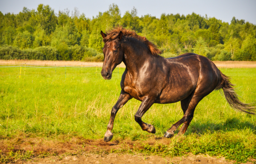

In [22]:
dest = "cavalo.jpg"
download_url(urls[0], dest, show_progress=False)
im = Image.open(dest).convert("RGB")
im.to_thumb(256, 256)

Agora faz o mesmo para fotos de "jumentos":

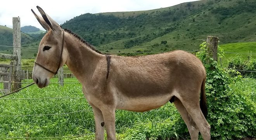

In [23]:
download_url(
  search_images("fotos jumentos", max_images=1)[0],
  "jumento.jpg",
  show_progress=False
)

Image.open("jumento.jpg").to_thumb(256, 256)

Pegar 200 exemplos de cada uma das fotos de "cavalos" e "jumentos" e salvar cada grupo de fotos em uma pasta diferente:

In [24]:
# Montagem do dataset
searches = ("jumentos", "cavalos")
path = Path("cavalo_ou_nao")

for o in searches:
  dest = (path/o)
  dest.mkdir(exist_ok=True, parents=True)
  download_images(dest, urls=search_images(f"{o} photo"))
  sleep(10)
  download_images(dest, urls=search_images(f"{o} sun photo"))
  sleep(10)
  download_images(dest, urls=search_images(f"{o} shade photo"))
  sleep(10)
  resize_images(path/o, max_size=400, dest=path/o)

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


# Treinamento do modelo

In [25]:
# Limpeza
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
print(f"Imagens inválidas removidas: {len(failed)}")

Imagens inválidas removidas: 3


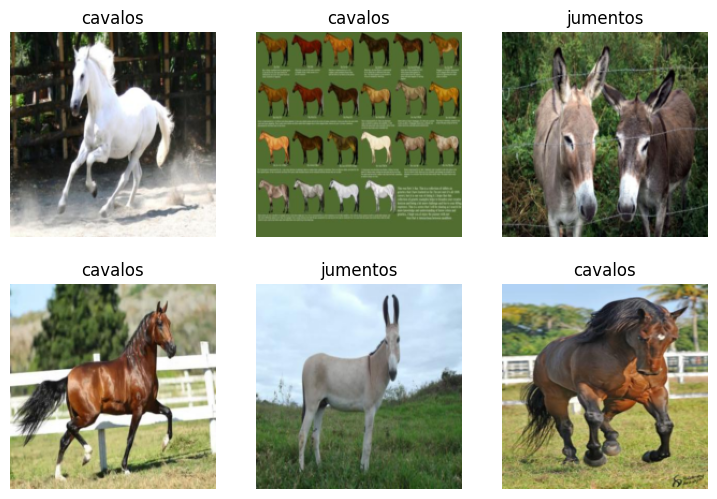

In [26]:
# DataLoaders
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method="squish")]
).dataloaders(path)

dls.show_batch(max_n=6)

In [27]:
# Cria modelo de classificação de imagens (learner) usando a rede ResNet18 já pré-treinada
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.711093,0.325394,0.062500,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.157838,0.082613,0.019231,00:03
1,0.092215,0.046234,0.004808,00:03
2,0.060672,0.051396,0.019231,00:04


In [28]:
# Predição em imagem de teste
pred, _, probs = learn.predict(PILImage.create("cavalo.jpg"))
print(f"Essa imagem é de um: {pred}.")
print(dict(zip(dls.vocab, map(float, probs))))

Essa imagem é de um: cavalos.
{'cavalos': 0.9991698265075684, 'jumentos': 0.0008302329224534333}


#Testando modelo com outras imagens

In [29]:
uploaded = files.upload()

fname = next(iter(uploaded))
img = PILImage.create(fname)
pred, _, probs = learn.predict(img)

Saving h_1.png to h_1 (1).png


In [31]:
print(f"Essa imagem é de um: {pred}.")
print(dict(zip(dls.vocab, map(float, probs))))

Essa imagem é de um: cavalos.
{'cavalos': 0.9999995231628418, 'jumentos': 5.183255211704818e-07}
